#CNN/LSTM models

In [31]:
#import libraries
import pandas as pd
import numpy as np
from google.colab import drive
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from torch.utils.data import DataLoader
import time

Dowload data

In [32]:
drive.mount('/content/gdrive')

#import time series
datasets = {}
for name in ['sp500', 'eur_usd']:
    datasets[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/Datasets/{name}_data.csv', index_col=0)
    datasets[name] = datasets[name]
    datasets[name].index.name = 'Date'
    datasets[name].index = pd.to_datetime(datasets[name].index)


Close_price = {}
Log_return = {}
test_residuals = {}
val_residuals = {}
SARIMA_fitted_values = {}
SARIMA_test_predictions = {}
residuals = {}

for name , dataset in datasets.items():

    #save Close price and Log Returns into a pd.Series
    Close_price[name] = dataset['Close'].copy().astype(float)
    # Log_return[name] = dataset['Log Return'].copy().astype(float)

    #drop columns not needed
    # dataset.drop(['Open', 'High', 'Low', 'Close', 'Log Return'], axis=1, inplace=True)
    dataset.drop(['Open', 'High', 'Low', 'Close'], axis=1, inplace=True)


    #import SARIMA residuals
    residuals[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_residuals.csv', index_col=0, sep=",")
    residuals[name].index = pd.to_datetime(residuals[name].index)


    #val residuals
    val_residuals[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_val_residuals.csv', index_col=0, sep=",")
    val_residuals[name].index = pd.to_datetime(val_residuals[name].index)

    #test residuals
    test_residuals[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_test_residuals.csv', index_col=0, sep=",")
    test_residuals[name].index = pd.to_datetime(test_residuals[name].index)

    #import SARIMA fitted values (predictions on the training set)
    SARIMA_fitted_values[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_fitted_values.csv', index_col=0)
    SARIMA_fitted_values[name].index = pd.to_datetime(SARIMA_fitted_values[name].index)

    #import SARIMA predictions on the test set
    SARIMA_test_predictions[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_test_predictions.csv', index_col=0).squeeze() #to read as a pd.Series
    SARIMA_test_predictions[name].index = pd.to_datetime(SARIMA_test_predictions[name].index)

Mounted at /content/gdrive


##Helper functions to move data to the GPU

In [33]:
#define some helper classes
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    return device

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, torch.Tensor):  # Only move tensors to the device
        return data.to(device, non_blocking=True)
    else:
        return data  # For non-tensor types (e.g., strings), return as is


class DeviceDataLoader (): #receive a dataloader and move to the correct device
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for batch in iter(self.dl):
      yield to_device(batch, device)

  def __len__(self):
    return len(self.dl)


#get device
device = get_device()

##Univariate sliding windows

In [34]:
def sliding_windows(data, seq_length):
    X, y = [], []

    for i in range(len(data) - seq_length ):
        _x = data.iloc[i:i+seq_length]
        _y = data.iloc[i + seq_length]
        X.append(_x)
        y.append(_y)

    return np.array(X), np.array(y)


train_data = {}
val_data = {}
test_data = {}
train_val_data = {}
scaler = {}

train_data_scaled = {}
val_data_scaled = {}
test_data_scaled = {}
train_val_data_scaled = {}

X_train = {}
X_val = {}
X_test = {}
X_train_val = {}
y_train = {}
y_val = {}
y_test = {}
y_train_val = {}


for name, dataset in datasets.items():

    #univariate sliding window
    train_data[name] = val_residuals[name].loc[:'2020']
    train_data[name].index = pd.to_datetime(val_residuals[name].loc[:'2020'].index)

    val_data[name] = val_residuals[name].loc['2021':]
    val_data[name].index = pd.to_datetime(val_residuals[name].loc['2021':].index)

    test_data[name] = test_residuals[name]
    test_data[name].index = pd.to_datetime(test_residuals[name].index)

    train_val_data[name] = val_residuals[name]
    train_val_data[name].index = pd.to_datetime(val_residuals[name].index)


    #scale the data
    if name == "sp500":
        scaler[name] = MinMaxScaler(feature_range=(-1, 1)) #initilise scaler
        # scaler = MinMaxScaler(feature_range=(-1, 1)) #initilise scaler
        # scaler = StandardScaler()

    elif name == "eur_usd":
        scaler[name] = MinMaxScaler(feature_range=(-1, 1))
        # scaler[name] = StandardScaler()
        # scaler[name] = RobustScaler()


    train_data_scaled[name] = pd.DataFrame(scaler[name].fit_transform(train_data[name].values.reshape(-1, 1)))
    val_data_scaled[name] = pd.DataFrame(scaler[name].transform(val_data[name].values.reshape(-1, 1)))
    train_val_data_scaled[name] = pd.DataFrame(scaler[name].fit_transform(train_val_data[name].values.reshape(-1, 1)))
    test_data_scaled[name] = pd.DataFrame(scaler[name].transform(test_data[name].values.reshape(-1, 1)))


    #sliding windows
    X_train[name], y_train[name]  = sliding_windows(train_data_scaled[name], 10)
    X_test[name] , y_test[name] = sliding_windows(test_data_scaled[name], 10)
    X_val[name], y_val[name] = sliding_windows(val_data_scaled[name], 10)
    X_train_val[name], y_train_val[name] = sliding_windows(train_val_data_scaled[name], 10)

Covert data into tensor

In [35]:
#create a custom dataset
class Custom_df(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index): #this method allows to retrieve a specific sample from the dataset based on its index (the index is passed to this method)
        input = torch.tensor(np.array(self.x[index]), dtype=torch.float32) #convert np array into a tensor
        target = torch.tensor(np.array(self.y[index]), dtype=torch.float32)
        return input, target

    def __len__(self):
        return len(self.x)


train_df = {}
test_df = {}
val_df = {}
train_val_df = {}

train_loader = {}
test_loader = {}
val_loader = {}
train_val_loader = {}

for name, dataset in datasets.items():

    #istance of the custom dataset class
    train_df[name] = Custom_df(X_train[name], y_train[name])
    test_df[name] = Custom_df(X_test[name], y_test[name])
    val_df[name] = Custom_df(X_val[name], y_val[name])
    train_val_df[name] = Custom_df(X_train_val[name], y_train_val[name])


    #create dataloaders (to perform training/inference in batch)
    batch_size = 128
    num_workers = 2

    train_loader[name] = DataLoader(train_df[name], batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
    test_loader[name] = DataLoader(test_df[name], batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
    val_loader[name] = DataLoader(val_df[name], batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
    train_val_loader[name] = DataLoader(train_val_df[name], batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)


    #get device
    device = get_device()


    #move to device
    train_loader[name] = DeviceDataLoader(train_loader[name], device)
    test_loader[name] = DeviceDataLoader(test_loader[name], device)
    val_loader[name] = DeviceDataLoader(val_loader[name], device)
    train_val_loader[name] = DeviceDataLoader(train_val_loader[name], device)

##Neural network models

LSTM followed by CNN

In [36]:
#custom loss
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


#istance of the custom loss
rmse_loss = torch.nn.MSELoss().to(device) #the loss is computed off the mse loss, the function return the rmse for easier comprehension


class LSTM_CNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__() #initialize the parent class
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True) #This argument specifies the input and output tensors are provided as (batch, seq, feature)
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=hidden_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            #flatten
            nn.Flatten(),
            nn.LazyLinear(out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=num_classes)
        )

    def forward(self, x):
        out, _ = self.lstm(x)  #stateless LSTM each batch is using a different hidden/cell state (initialized to 0)
        out = out.permute(0, 2, 1)
        out = self.cnn(out)
        # out = out.squeeze(-1)
        # print(out)
        return out

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
LSTM_CNN_model = {}

for name, dataset in datasets.items():

    num_classes = 1 # regression
    # input_size = 32  # Number of features per time step
    input_size = 1 #number of input features
    hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
    num_layers = 1

    LSTM_CNN_model[name] = LSTM_CNN(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
    LSTM_CNN_model[name].to(device) #move the istance to the device

CNN + LSTM parallel architecture

In [37]:
class ParallelCNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(out_features=128), #linear layer that automatically infer the input size
            nn.ReLU()
        )
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_lstm = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128*2, num_classes)

    def forward(self, x):
        #cnn takes input of shape (batch_size, channels, seq_len)
        x_cnn = x.permute(0, 2, 1)
        out_cnn = self.cnn(x_cnn)
        # lstm takes input of shape (batch_size, seq_len, input_size)
        out_lstm, _ = self.lstm(x)
        out_lstm = self.fc_lstm(out_lstm[:, -1, :])
        out = torch.cat([out_cnn, out_lstm], dim=1)
        out = self.fc(out)
        return out

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
parallelCNNLSTM_model = {}

for name, dataset in datasets.items():

    num_classes = 1 # regression
    # input_size = 32  # Number of features per time step
    input_size = 1 #number of input features
    hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
    num_layers = 1

    parallelCNNLSTM_model[name] = ParallelCNN_LSTM(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
    parallelCNNLSTM_model[name].to(device) #move the istance to the device

In [38]:
#custom loss
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


#istance of the custom loss
rmse_loss = torch.nn.MSELoss().to(device) #the loss is computed off the mse loss, the function return the rmse for easier comprehension

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size=512, num_layers=3, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, self.num_classes)

        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # LSTM output
        lstm_out, _ = self.lstm(x)

        # Pass only the last output
        lstm_out = lstm_out[:, -1, :]

        # Fully connected layers with ReLU and Dropout
        x = self.relu(self.fc1(lstm_out))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # Final prediction
        return x

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
LSTM_model = {}

for name, dataset in datasets.items():

    num_classes = 1 # regression
    # input_size = 32  # Number of features per time step
    input_size = 1 #number of input features
    hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
    num_layers = 3

    LSTM_model[name] = LSTM(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
    LSTM_model[name].to(device) #move the istance to the device

CNN model

In [39]:
class CNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(out_features=128), #linear layer that automatically infer the input size
            nn.ReLU()
        )
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        #cnn takes input of shape (batch_size, channels, seq_len)
        x_cnn = x.permute(0, 2, 1)
        out_cnn = self.cnn(x_cnn)
        out = self.fc(out_cnn)
        return out

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
CNN_model = {}

for name, dataset in datasets.items():

    num_classes = 1 # regression
    # input_size = 32  # Number of features per time step
    input_size = 1 #number of input features
    hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
    num_layers = 1

    CNN_model[name] = CNN(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
    CNN_model[name].to(device) #move the istance to the device

##Training

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit(epochs, lr, model, train_loader, val_loader, warmup_epochs, weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache() #clear the unused memory from the GPU
    history = []
    # best_val_loss = float('inf') #initialized to the largest possible value
    # no_improve_count = 0  # Count epochs with no improvement in validation loss

    optimizer = opt_func(model.parameters(), lr, weight_decay= weight_decay) #updates the model weights according to the learnign rate

    # Warm-up scheduler (linear increase of the learning rate during warm-up)
    warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: (epoch + 1) / warmup_epochs if epoch < warmup_epochs else 1)

    #Annealing scheduler (decrease the lr after the warm-up)
    annealing_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                          patience=5, #defines how many epochs to wait for an improvement
                                                          factor =0.5 , #factor by which the learning rate will be reduced
                                                          min_lr=1e-7, #sets the minimum learning rate that the scheduler can reach
                                                          eps=1e-08) #small value added to the learning rate for numerical stability

    for epoch in range(epochs):
        model.train()
        train_losses =[]
        lrs = []

        for batch in train_loader:
        #training loop
            input, output = batch
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward() #compute gradients

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip) #gradient clippping

            optimizer.step() #update weights
            optimizer.zero_grad() #reset gradients

        #update lr
        if epoch < warmup_epochs:
            warmup_scheduler.step()
            if epoch == 0:
                print("warmup phase")
        else:
            annealing_scheduler.step(result['val_loss'])
            if epoch == warmup_epochs:
                print("annealing phase")

        #track lr
        lrs.append(get_lr(optimizer))

        #validation loop
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        #scheduler.step(result['val_loss'])

        # if result['val_loss'] < best_val_loss:
        #     best_val_loss = result['val_loss']
        #     print(f"best vall loss: {best_val_loss}")
        #     no_improve_count = 0  # Reset counter on improvement
        # else:
        #     print(f"No improvement , current val loss: {result['val_loss']} best loss: {best_val_loss}")
        #     no_improve_count += 1  # Increment counter if no improvement


        model.epoch_end(epoch, result) #print results
        history.append(result)

        # if no_improve_count >= 50:
        #     print(f"No improvement in validation loss for {no_improve_count} epochs. Stopping training.")
        #     break

    return history

Train all the NN models at once

In [ ]:
import time
import itertools


models = [LSTM_model, CNN_model, parallelCNNLSTM_model, LSTM_CNN_model]

for name, _ in datasets.items():

    if name == 'sp500':
        continue

    for model in models:
        print(f"training model {model[name].__class__.__name__} on {name} dataset:")
        #evaluate untrained model
        history = [evaluate(model[name], val_loader[name])]

        #train model
        if (model[name] == parallelCNNLSTM_model[name]):
            epochs = 300
            warmup_epochs = 20
        elif (model[name] == LSTM_model[name]):
            epochs = 300
            warmup_epochs = 30
        elif(model[name] == CNN_model[name]):
            epochs = 300
            warmup_epochs = 40
        elif(model[name] ==LSTM_CNN_model[name]):
            warmup_epochs = 30
            epochs = 300

        # max_lr = 0.001
        max_lr = 0.001
        grad_clip = None
        weight_decay = 1e-5
        opt_func = torch.optim.Adam


        start_time = time.time()
        if name == 'sp500':
            history += fit(epochs, max_lr, model[name], train_loader[name], val_loader[name], warmup_epochs, weight_decay, grad_clip, opt_func)
        elif name == 'eur_usd':
            history += fit(epochs, max_lr, model[name], train_loader[name], val_loader[name], warmup_epochs, weight_decay, grad_clip, opt_func)
        end_time = time.time()
        print(f"Training time: {end_time - start_time} seconds")

        #visualize val_loss
        plt.figure(figsize=(12, 6))
        val_loss = [x['val_loss'] for x in history]
        sns.lineplot(val_loss, label = "loss on validation set")
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Validation Loss')
        plt.show()

        #vsìisualize learning rate schedule
        plt.figure(figsize=(12, 6))
        lr = [x['lrs'] for x in history[1:]]
        # sns.lineplot(lr, label = "learning rate schedule")
        sns.lineplot(list(itertools.chain(*lr)), label = "learning rate schedule")
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule')
        plt.legend()
        plt.show()

training model LSTM on eur_usd dataset:
warmup phase
Epoch [0], last_lr: 0.00007, train_loss: 0.6072, val_loss: 0.5261
Epoch [1], last_lr: 0.00010, train_loss: 0.6055, val_loss: 0.5233
Epoch [2], last_lr: 0.00013, train_loss: 0.6025, val_loss: 0.5184
Epoch [3], last_lr: 0.00017, train_loss: 0.5982, val_loss: 0.5112
Epoch [4], last_lr: 0.00020, train_loss: 0.5942, val_loss: 0.5016
Epoch [5], last_lr: 0.00023, train_loss: 0.5871, val_loss: 0.4884
Epoch [6], last_lr: 0.00027, train_loss: 0.5747, val_loss: 0.4682
Epoch [7], last_lr: 0.00030, train_loss: 0.5538, val_loss: 0.4292
Epoch [8], last_lr: 0.00033, train_loss: 0.4870, val_loss: 0.3119
Epoch [9], last_lr: 0.00037, train_loss: 0.2507, val_loss: 0.1495
Epoch [10], last_lr: 0.00040, train_loss: 0.3954, val_loss: 0.1973
Epoch [11], last_lr: 0.00043, train_loss: 0.3110, val_loss: 0.2492
Epoch [12], last_lr: 0.00047, train_loss: 0.3111, val_loss: 0.2169
Epoch [13], last_lr: 0.00050, train_loss: 0.2014, val_loss: 0.1179
Epoch [14], last_lr

##Fine Tune

In [75]:
name = 'eur_usd'
models = [LSTM_model, CNN_model, parallelCNNLSTM_model, LSTM_CNN_model]

for model in models:
    print(model[name].__class__.__name__)
    for pname, param in model[name].named_parameters():
        print(pname)

LSTM
lstm.weight_ih_l0
lstm.weight_hh_l0
lstm.bias_ih_l0
lstm.bias_hh_l0
lstm.weight_ih_l1
lstm.weight_hh_l1
lstm.bias_ih_l1
lstm.bias_hh_l1
lstm.weight_ih_l2
lstm.weight_hh_l2
lstm.bias_ih_l2
lstm.bias_hh_l2
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias
CNN
cnn.0.weight
cnn.0.bias
cnn.3.weight
cnn.3.bias
cnn.7.weight
cnn.7.bias
fc.weight
fc.bias
ParallelCNN_LSTM
cnn.0.weight
cnn.0.bias
cnn.3.weight
cnn.3.bias
cnn.7.weight
cnn.7.bias
lstm.weight_ih_l0
lstm.weight_hh_l0
lstm.bias_ih_l0
lstm.bias_hh_l0
fc_lstm.weight
fc_lstm.bias
fc.weight
fc.bias
LSTM_CNN
lstm.weight_ih_l0
lstm.weight_hh_l0
lstm.bias_ih_l0
lstm.bias_hh_l0
cnn.0.weight
cnn.0.bias
cnn.3.weight
cnn.3.bias
cnn.7.weight
cnn.7.bias
cnn.9.weight
cnn.9.bias


In [13]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit(epochs, lr, model, train_loader, val_loader, warmup_epochs, weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):

    torch.cuda.empty_cache() #clear the unused memory from the GPU
    history = []
    # best_val_loss = float('inf') #initialized to the largest possible value
    # no_improve_count = 0  # Count epochs with no improvement in validation loss

    # optimizer = opt_func(model.parameters(), lr, weight_decay= weight_decay) #updates the model weights according to the learnign rate

    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay = weight_decay) #optimizer only for the layer that requires gradient
    # Warm-up scheduler (linear increase of the learning rate during warm-up)
    warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: (epoch + 1) / warmup_epochs if epoch < warmup_epochs else 1)

    #Annealing scheduler (decrease the lr after the warm-up)
    annealing_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                        patience=5, #defines how many epochs to wait for an improvement
                                                        factor =0.5 , #factor by which the learning rate will be reduced
                                                        min_lr=1e-7, #sets the minimum learning rate that the scheduler can reach
                                                        eps=1e-08) #small value added to the learning rate for numerical stability


    for epoch in range(epochs):
        model.train()
        train_losses =[]
        lrs = []

        for batch in train_loader:
        #training loop
            input, output = batch
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward() #compute gradients

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip) #gradient clippping

            optimizer.step() #update weights
            optimizer.zero_grad() #reset gradients

        #update lr
        if epoch < warmup_epochs:
            warmup_scheduler.step()
            if epoch == 0:
                print("warmup phase")
        else:
            annealing_scheduler.step(result['val_loss'])
            if epoch == warmup_epochs:
                print("annealing phase")

        #track lr
        lrs.append(get_lr(optimizer))

        #validation loop
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        #scheduler.step(result['val_loss'])

        # if result['val_loss'] < best_val_loss:
        #     best_val_loss = result['val_loss']
        #     print(f"best vall loss: {best_val_loss}")
        #     no_improve_count = 0  # Reset counter on improvement
        # else:
        #     print(f"No improvement , current val loss: {result['val_loss']} best loss: {best_val_loss}")
        #     no_improve_count += 1  # Increment counter if no improvement


        model.epoch_end(epoch, result) #print results
        history.append(result)

        # if no_improve_count >= 50:
        #     print(f"No improvement in validation loss for {no_improve_count} epochs. Stopping training.")
        #     break

    return history



training model LSTM on eur_usd dataset:
Training time: 0.017597675323486328 seconds


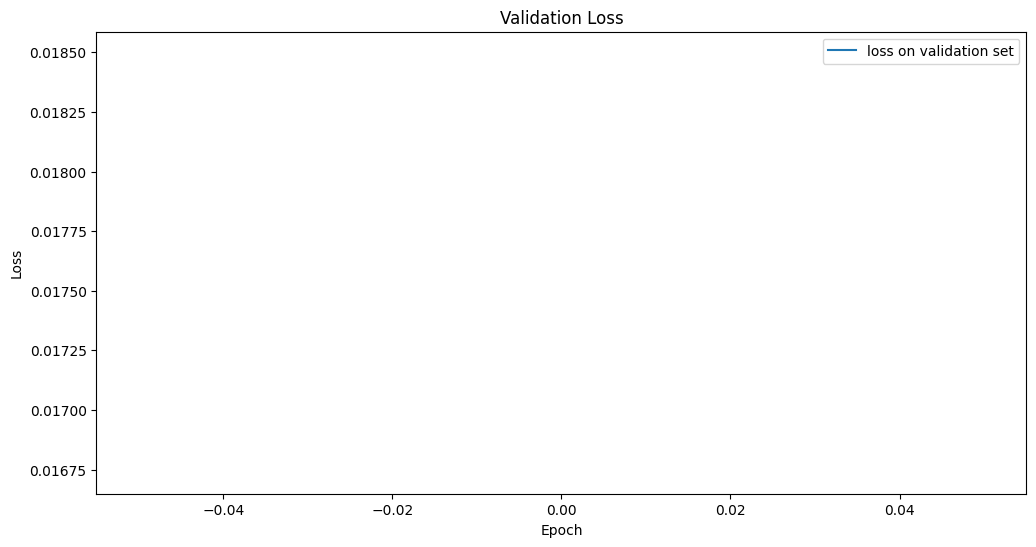

<ipython-input-21-c2b2a463e738>:102: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


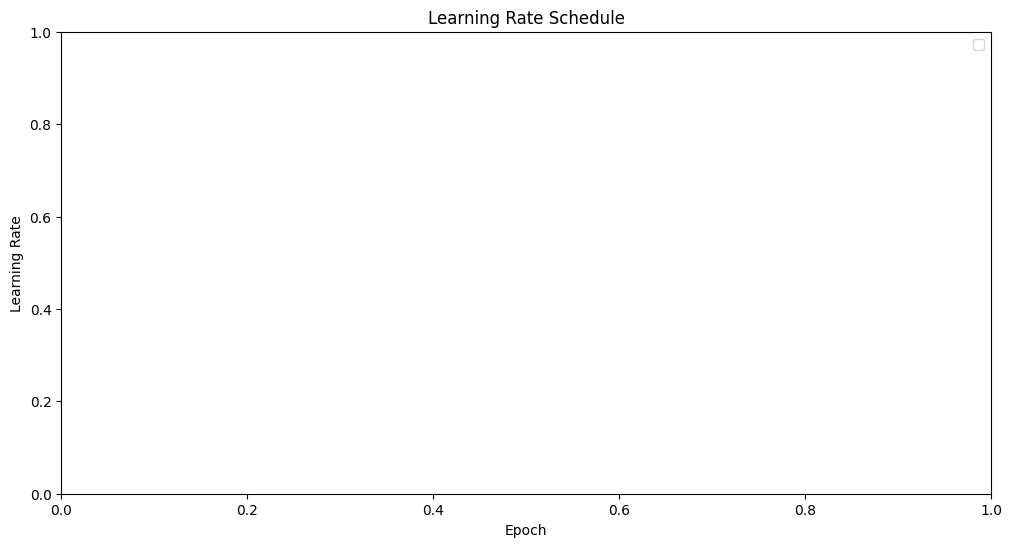

training model CNN on eur_usd dataset:
warmup phase
Epoch [0], last_lr: 0.00001, train_loss: 0.0213, val_loss: 0.0121
Epoch [1], last_lr: 0.00001, train_loss: 0.0211, val_loss: 0.0121
Epoch [2], last_lr: 0.00001, train_loss: 0.0209, val_loss: 0.0122
Epoch [3], last_lr: 0.00001, train_loss: 0.0206, val_loss: 0.0123
Epoch [4], last_lr: 0.00002, train_loss: 0.0204, val_loss: 0.0125
Epoch [5], last_lr: 0.00002, train_loss: 0.0201, val_loss: 0.0126
Epoch [6], last_lr: 0.00002, train_loss: 0.0199, val_loss: 0.0127
Epoch [7], last_lr: 0.00002, train_loss: 0.0196, val_loss: 0.0128
Epoch [8], last_lr: 0.00003, train_loss: 0.0193, val_loss: 0.0127
Epoch [9], last_lr: 0.00003, train_loss: 0.0190, val_loss: 0.0127
Epoch [10], last_lr: 0.00003, train_loss: 0.0187, val_loss: 0.0127
Epoch [11], last_lr: 0.00003, train_loss: 0.0183, val_loss: 0.0128
Epoch [12], last_lr: 0.00003, train_loss: 0.0180, val_loss: 0.0129
Epoch [13], last_lr: 0.00004, train_loss: 0.0176, val_loss: 0.0131
Epoch [14], last_lr:

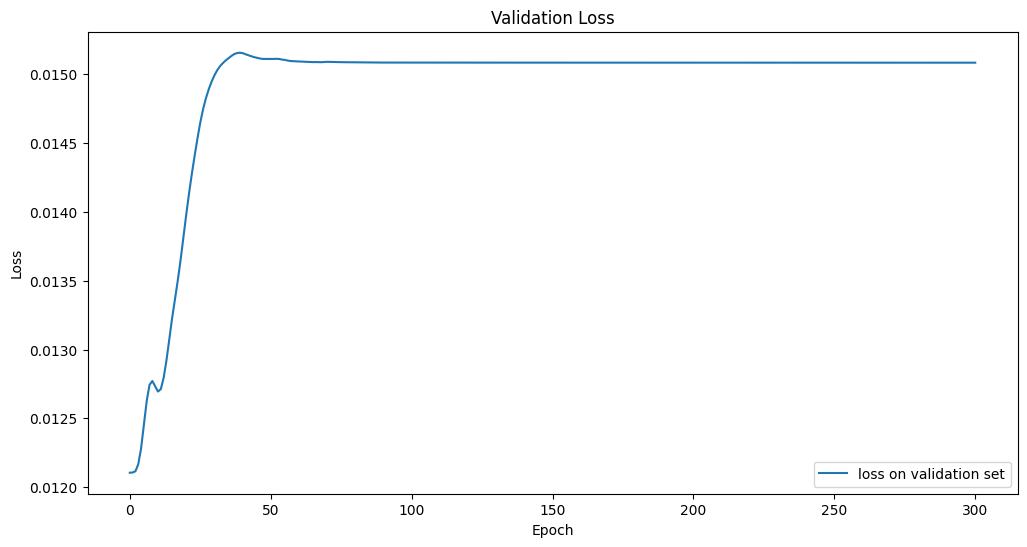

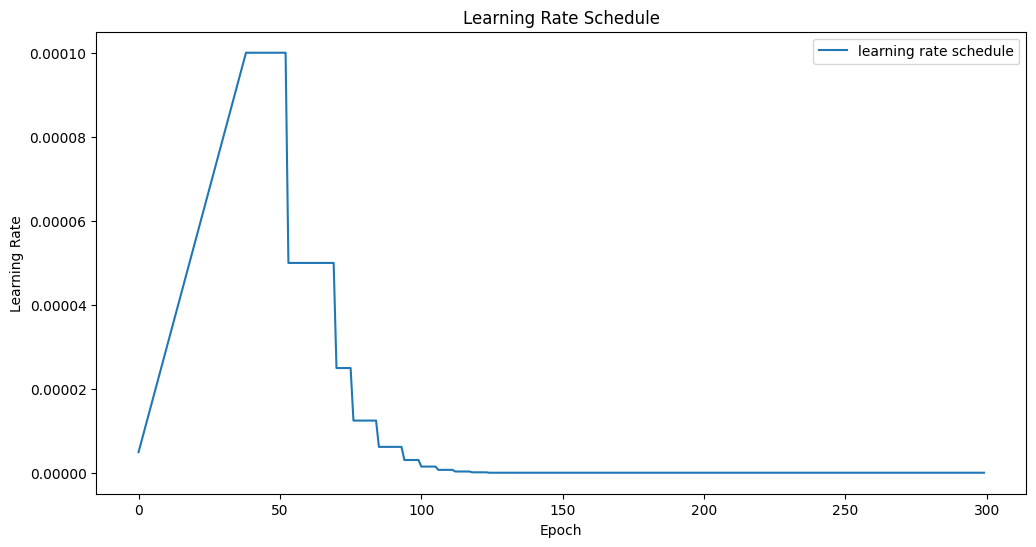

training model ParallelCNN_LSTM on eur_usd dataset:
warmup phase
Epoch [0], last_lr: 0.00001, train_loss: 0.0199, val_loss: 0.0122
Epoch [1], last_lr: 0.00002, train_loss: 0.0196, val_loss: 0.0122
Epoch [2], last_lr: 0.00002, train_loss: 0.0192, val_loss: 0.0123
Epoch [3], last_lr: 0.00003, train_loss: 0.0188, val_loss: 0.0125
Epoch [4], last_lr: 0.00003, train_loss: 0.0184, val_loss: 0.0127
Epoch [5], last_lr: 0.00003, train_loss: 0.0180, val_loss: 0.0127
Epoch [6], last_lr: 0.00004, train_loss: 0.0174, val_loss: 0.0127
Epoch [7], last_lr: 0.00005, train_loss: 0.0168, val_loss: 0.0127
Epoch [8], last_lr: 0.00005, train_loss: 0.0162, val_loss: 0.0128
Epoch [9], last_lr: 0.00006, train_loss: 0.0155, val_loss: 0.0131
Epoch [10], last_lr: 0.00006, train_loss: 0.0149, val_loss: 0.0133
Epoch [11], last_lr: 0.00007, train_loss: 0.0144, val_loss: 0.0136
Epoch [12], last_lr: 0.00007, train_loss: 0.0139, val_loss: 0.0138
Epoch [13], last_lr: 0.00008, train_loss: 0.0135, val_loss: 0.0141
Epoch [

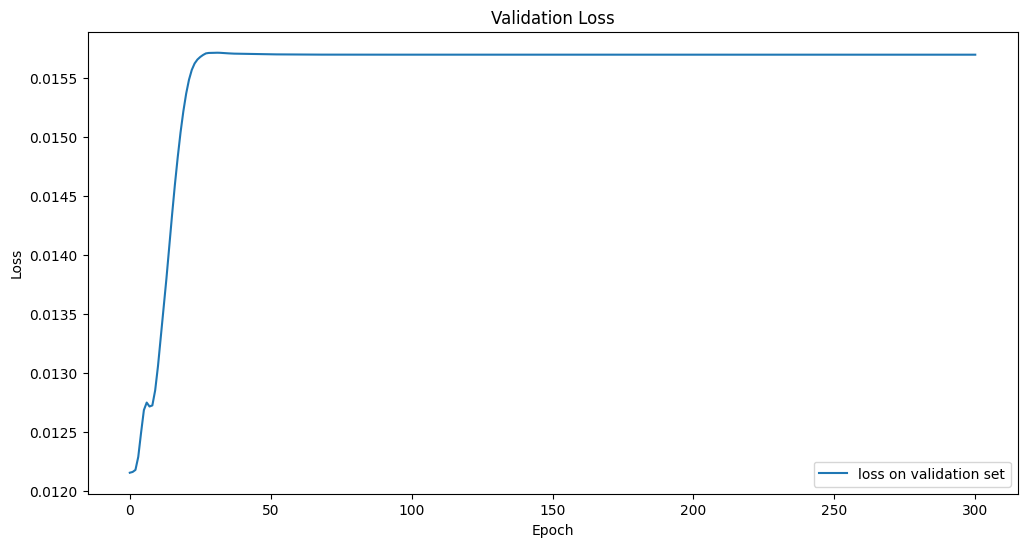

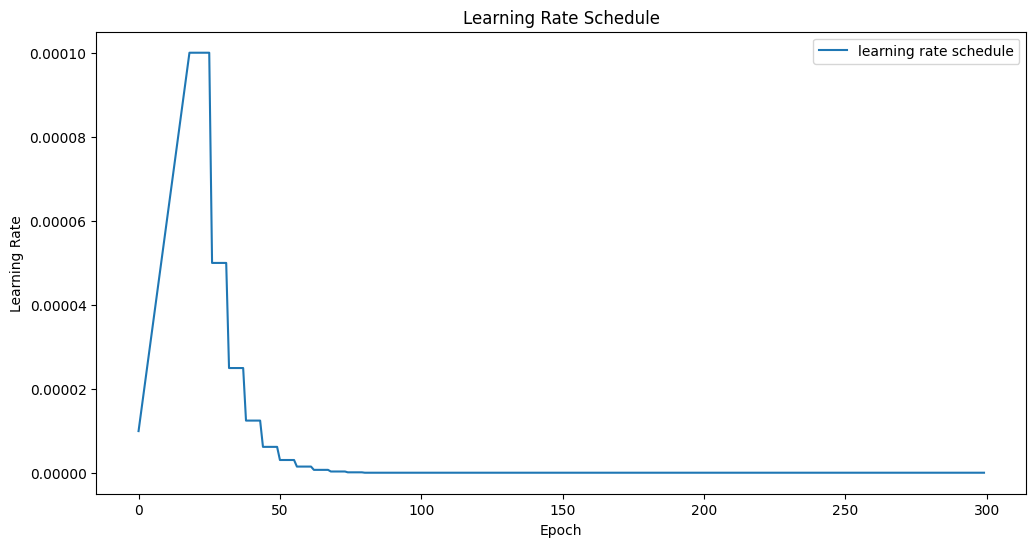

training model LSTM_CNN on eur_usd dataset:
warmup phase
Epoch [0], last_lr: 0.00001, train_loss: 0.0276, val_loss: 0.0132
Epoch [1], last_lr: 0.00001, train_loss: 0.0270, val_loss: 0.0135
Epoch [2], last_lr: 0.00001, train_loss: 0.0266, val_loss: 0.0141
Epoch [3], last_lr: 0.00002, train_loss: 0.0264, val_loss: 0.0144
Epoch [4], last_lr: 0.00002, train_loss: 0.0260, val_loss: 0.0141
Epoch [5], last_lr: 0.00002, train_loss: 0.0254, val_loss: 0.0137
Epoch [6], last_lr: 0.00003, train_loss: 0.0247, val_loss: 0.0136
Epoch [7], last_lr: 0.00003, train_loss: 0.0240, val_loss: 0.0139
Epoch [8], last_lr: 0.00003, train_loss: 0.0233, val_loss: 0.0142
Epoch [9], last_lr: 0.00004, train_loss: 0.0227, val_loss: 0.0142
Epoch [10], last_lr: 0.00004, train_loss: 0.0221, val_loss: 0.0143
Epoch [11], last_lr: 0.00004, train_loss: 0.0214, val_loss: 0.0145
Epoch [12], last_lr: 0.00005, train_loss: 0.0208, val_loss: 0.0147
Epoch [13], last_lr: 0.00005, train_loss: 0.0204, val_loss: 0.0148
Epoch [14], las

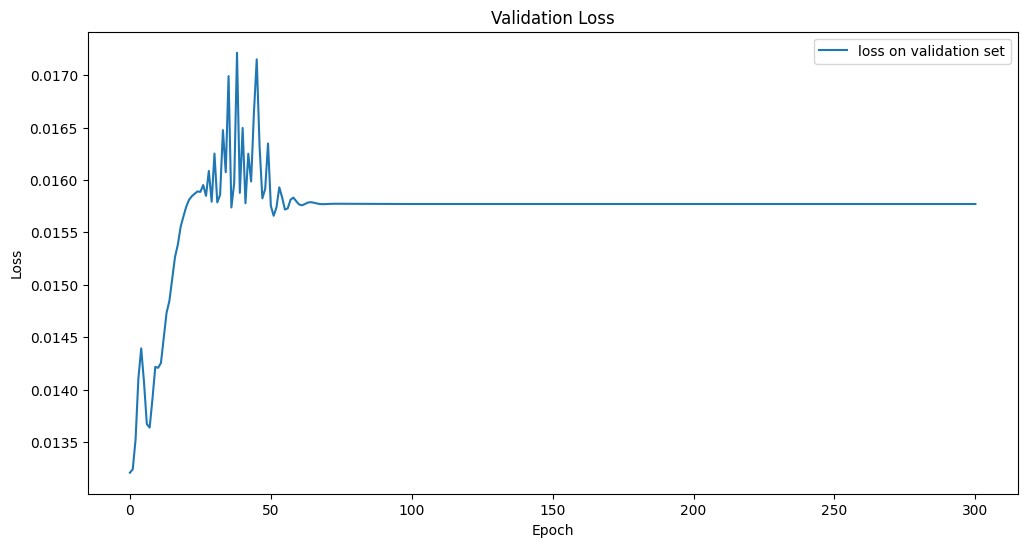

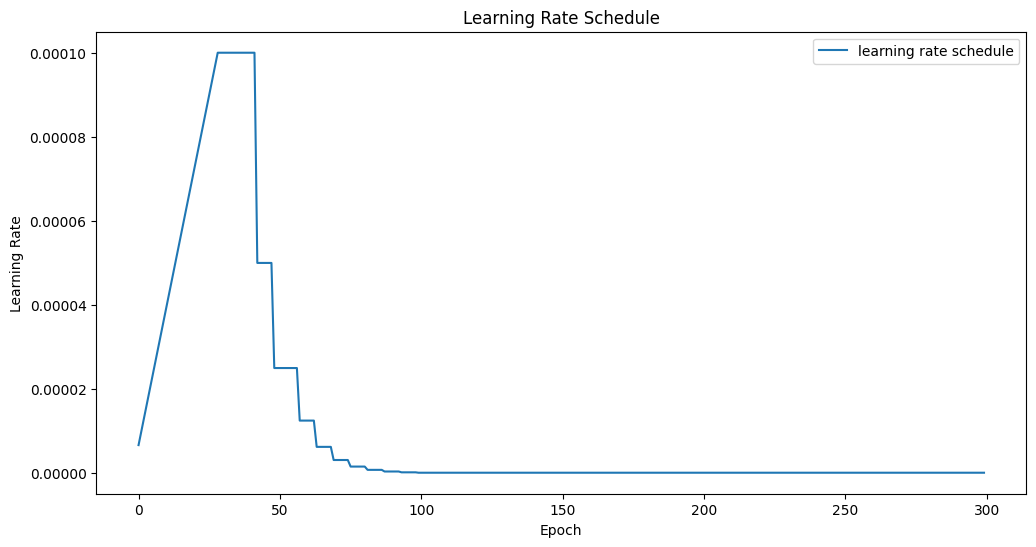

In [21]:
import time
import itertools


models = [LSTM_model, CNN_model, parallelCNNLSTM_model, LSTM_CNN_model]

for name, _ in datasets.items():

    if name == 'sp500':
        continue

    for model in models:
        print(f"training model {model[name].__class__.__name__} on {name} dataset:")
        #evaluate untrained model
        history = [evaluate(model[name], val_loader[name])]

        #train model
        if (model[name] == parallelCNNLSTM_model[name]):
            epochs = 300
            warmup_epochs = 20

            # freeze early layers (everything except 'fc' layers)
            for pname, param in model[name].named_parameters():
                if 'fc' in pname:  # adjust this condition based on your architecture
                    param.requires_grad = True
                elif "cnn.7" in pname:
                    param.requires_grad = True
                else:
                    param.requires_grad = False


        elif (model[name] == LSTM_model[name]):
            epochs = 0
            warmup_epochs = 30

            # freeze early layers (everything except 'fc' layers)
            for pname, param in model[name].named_parameters():
                if 'fc' in pname:  # adjust this condition based on your architecture
                    param.requires_grad = True
                else:
                    param.requires_grad = False

        elif(model[name] == CNN_model[name]):
            epochs = 300
            warmup_epochs = 40

            # freeze early layers (everything except 'fc' layers)
            for pname, param in model[name].named_parameters():
                if 'fc' in pname:  # adjust this condition based on your architecture
                    param.requires_grad = True
                elif "cnn.7" in pname:
                    param.requires_grad = True
                else:
                    param.requires_grad = False

        elif(model[name] ==LSTM_CNN_model[name]):
            warmup_epochs = 30
            epochs = 300

           # Freeze LSTM and CNN layers
            if "cnn.0" in pname or "cnn.3" in pname:
                param.requires_grad = False
            # Unfreeze Linear layers
            elif "cnn.7" in pname or "cnn.9" in pname:
                param.requires_grad = True
            elif "lstm.fc" in pname:
                param.requires_grad = False
            else:
                param.requires_grad = False


        # max_lr = 0.001
        max_lr = 1e-4
        grad_clip = None
        weight_decay = 1e-3
        opt_func = torch.optim.Adam


        start_time = time.time()
        history += fit(epochs, max_lr, model[name], train_loader[name], val_loader[name], warmup_epochs, weight_decay, grad_clip, opt_func)
        end_time = time.time()
        print(f"Training time: {end_time - start_time} seconds")

        #visualize val_loss
        plt.figure(figsize=(12, 6))
        val_loss = [x['val_loss'] for x in history]
        sns.lineplot(val_loss, label = "loss on validation set")
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Validation Loss')
        plt.show()

        #vsìisualize learning rate schedule
        plt.figure(figsize=(12, 6))
        lr = [x['lrs'] for x in history[1:]]
        # sns.lineplot(lr, label = "learning rate schedule")
        sns.lineplot(list(itertools.chain(*lr)), label = "learning rate schedule")
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule')
        plt.legend()
        plt.show()

##Save models state dict

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

models = [LSTM_model, CNN_model, parallelCNNLSTM_model, LSTM_CNN_model] #model istances


for name, _ in datasets.items():
    for model in models:
        model_name = model[name].__class__.__name__
        save_path = f'/content/drive/MyDrive/università/Tesi/models/{name}/{model_name}_fine_tuned'

        #save state dict of the model
        torch.save(model[name].state_dict(), save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load models

In [40]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

model_names = ['LSTM', 'CNN', 'ParallelCNN_LSTM', 'LSTM_CNN']
models = [LSTM_model, CNN_model, parallelCNNLSTM_model, LSTM_CNN_model] #model istannces


for name, _ in datasets.items():
    for model_name, model_istance in zip(model_names, models):
        model_path = f'/content/drive/MyDrive/università/Tesi/models/{name}/{model_name}_fine_tuned'

        #load state dict
        model_istance[name].load_state_dict(torch.load(model_path, map_location=torch.device(device)))


Mounted at /content/drive


<ipython-input-40-9efbc623b02c>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_istance[name].load_state_dict(torch.load(model_path, map_location=torch.device(device

##Batch inference

In [11]:
#helper function to make inference with batches
@torch.no_grad()
def inference(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actuals = []

    for batch in data_loader:
        input, output = batch  # Unpack your batch into input and output
        outputs = model(input) # Perform the forward pass

        # Move outputs and actuals back to CPU and append to lists
        predictions.append(outputs.cpu())
        actuals.append(output.cpu())

    # Concatenate all predictions and actuals into single tensors
    predictions = torch.cat(predictions, dim=0)
    actuals = torch.cat(actuals, dim=0)

    return predictions, actuals

model eur_usd: LSTM(
  (lstm): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


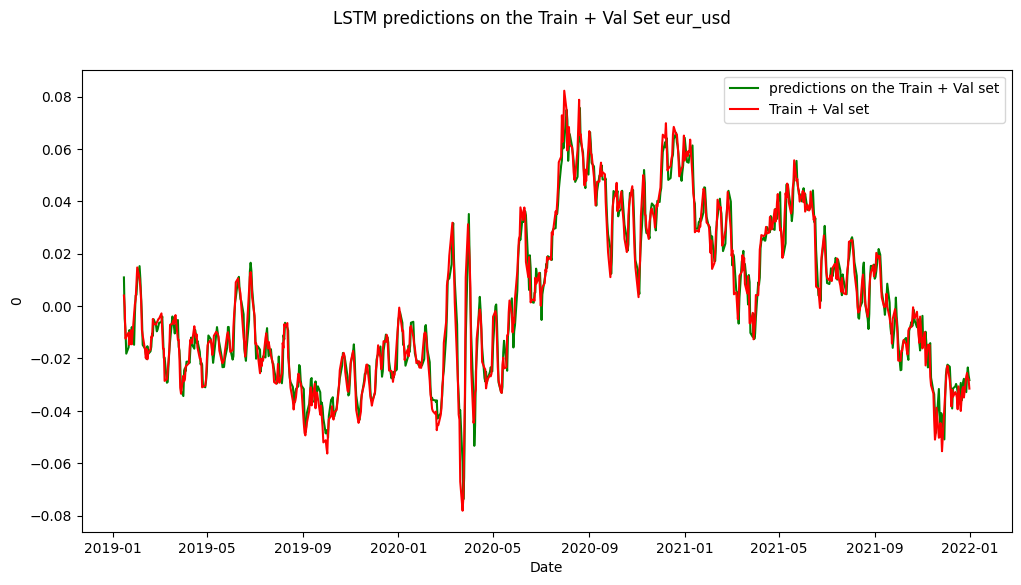

MSE: 3.225823350283701e-05
RMSE: 0.0056796332190412625
MAE: 0.004318055510837283
R2: 0.9656988956263025


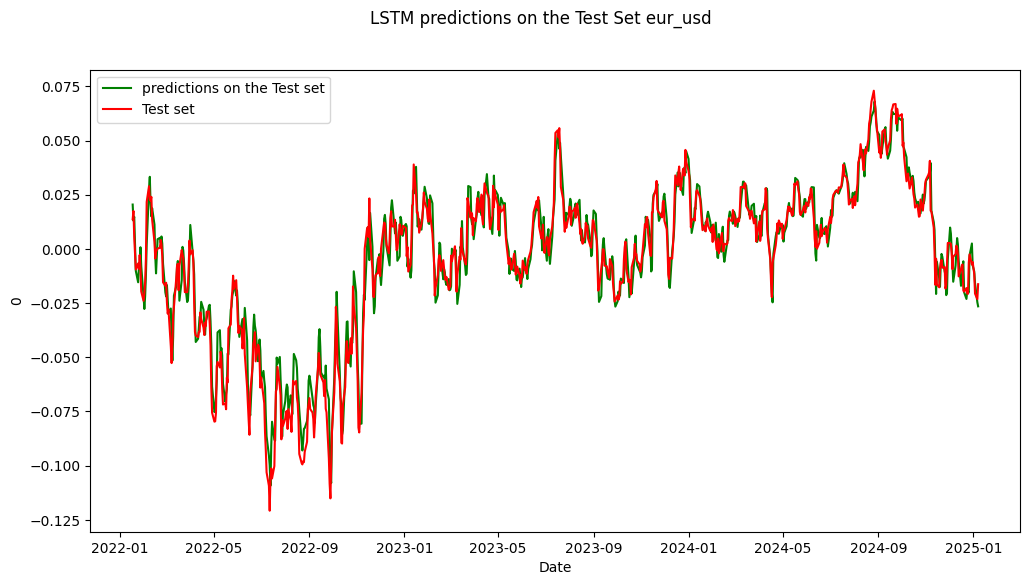

MSE: 6.118247262869178e-05
RMSE: 0.007821922566012258
MAE: 0.006064470511911824
R2: 0.9516138779816378
model eur_usd: CNN(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=128, bias=True)
    (8): ReLU()
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


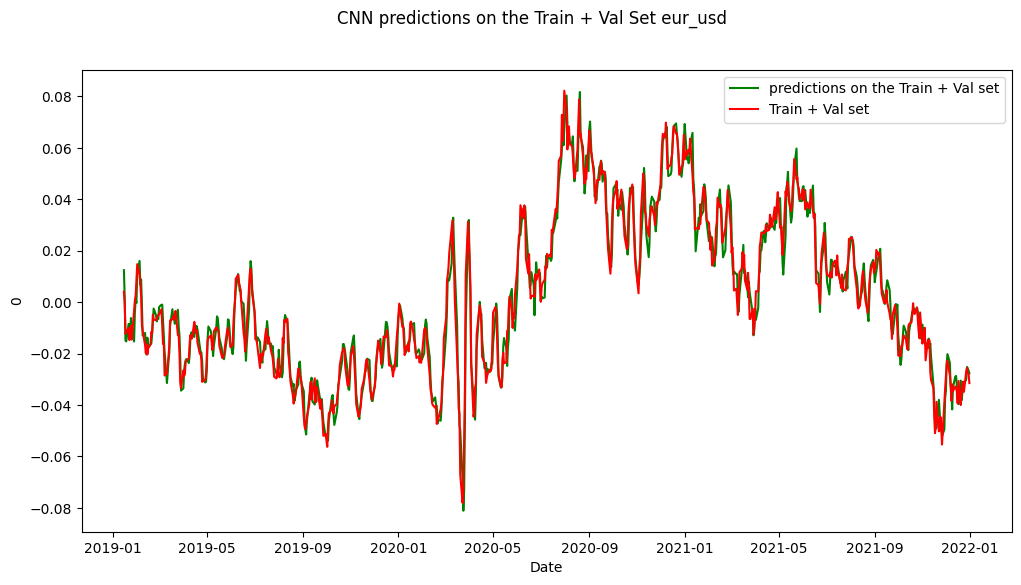

MSE: 2.9212064150313138e-05
RMSE: 0.00540481860475568
MAE: 0.0042013205482317
R2: 0.9689379748180286


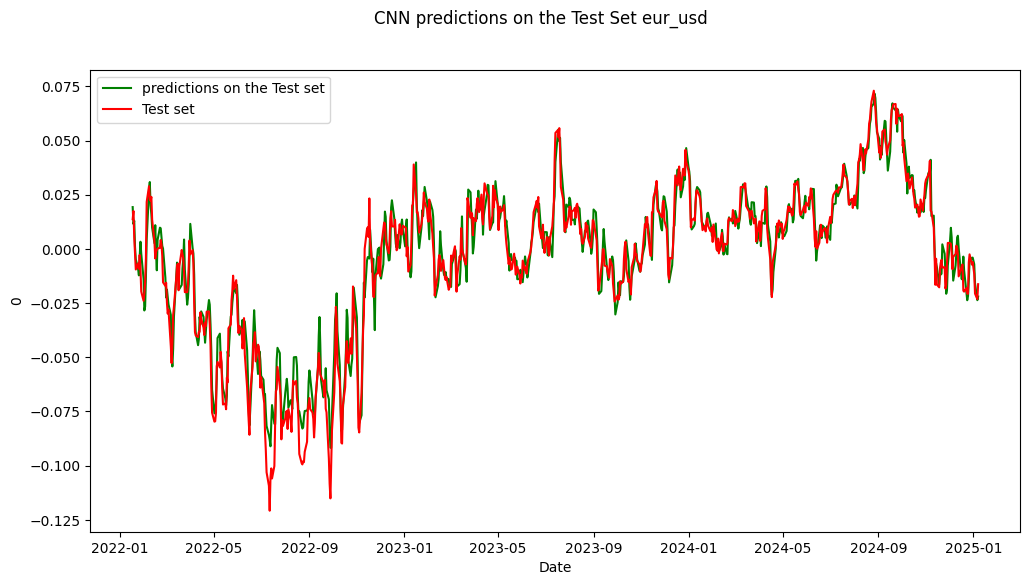

MSE: 6.38847265070333e-05
RMSE: 0.007992792159629405
MAE: 0.006082590917155927
R2: 0.9494768021122865
model eur_usd: ParallelCNN_LSTM(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=128, bias=True)
    (8): ReLU()
  )
  (lstm): LSTM(1, 512, batch_first=True)
  (fc_lstm): Linear(in_features=512, out_features=128, bias=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


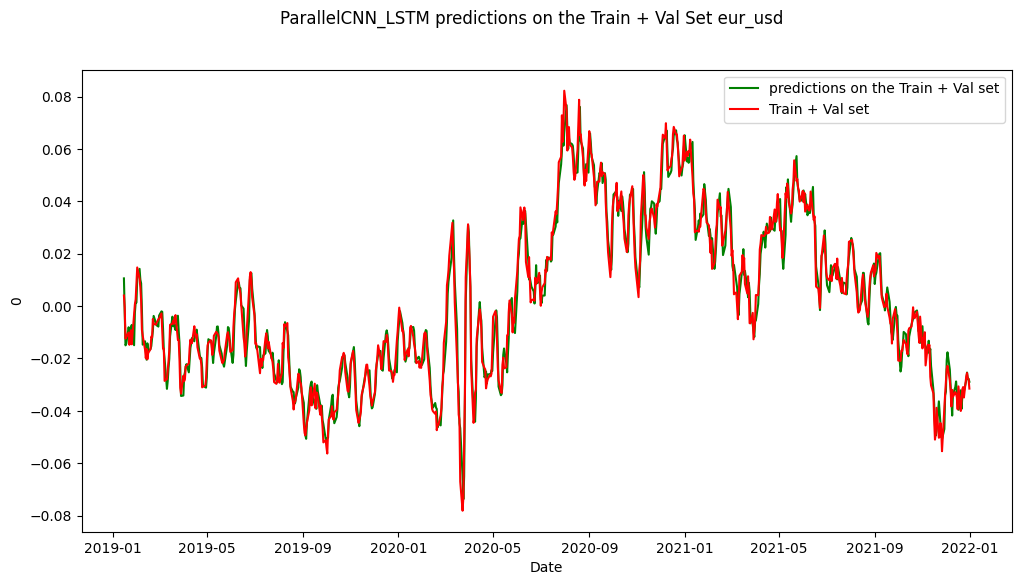

MSE: 2.502865473851449e-05
RMSE: 0.005002864653227637
MAE: 0.0038916066307718286
R2: 0.9733863139640452


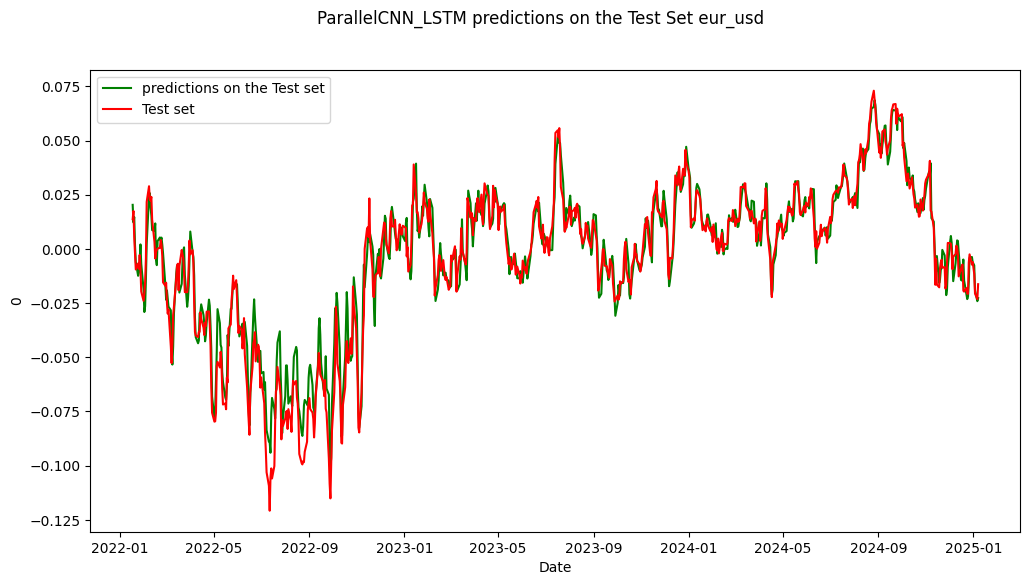

MSE: 6.929455539321493e-05
RMSE: 0.008324335132202147
MAE: 0.006158979992971919
R2: 0.9451984421614907
model eur_usd: LSTM_CNN(
  (lstm): LSTM(1, 512, batch_first=True)
  (cnn): Sequential(
    (0): Conv1d(512, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)


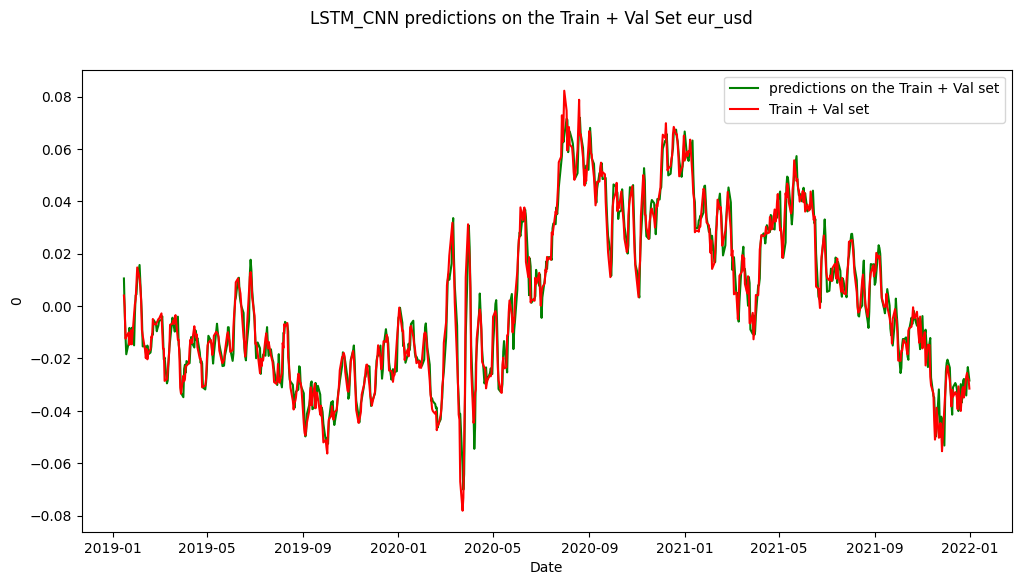

MSE: 3.103422722814215e-05
RMSE: 0.00557083721070201
MAE: 0.004232951838992121
R2: 0.9670004165846239


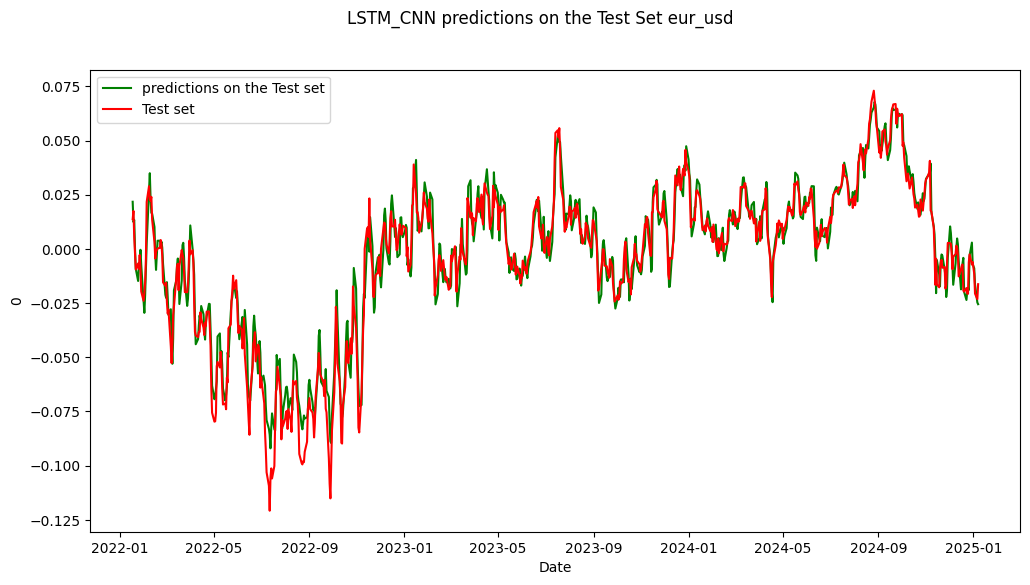

MSE: 6.661611667928716e-05
RMSE: 0.008161869680366574
MAE: 0.006225363123367426
R2: 0.9473166838222575


In [41]:
models = [LSTM_model, CNN_model, parallelCNNLSTM_model, LSTM_CNN_model]

for name, _ in datasets.items():

    if name == 'sp500':
        continue

    for model in models:
        print(f"model {name}: {model[name]}")
        model_name = model[name].__class__.__name__

        #batch inference
        prediction, actual = inference(model[name], test_loader[name])

        ## Inverse Scale
        prediction = scaler[name].inverse_transform(prediction)
        actual = scaler[name].inverse_transform(actual)


        #predictions on the test_loader
        prediction = pd.DataFrame(prediction)
        prediction.index = test_data[name][10:].index
        actual = pd.DataFrame(actual)
        actual.index = test_data[name][10:].index


        #predictions on the train_val_loader
        train_val_predictions, actual_train_val = inference(model[name], train_val_loader[name])

        ## Inverse Scale
        train_val_predictions = scaler[name].inverse_transform(train_val_predictions)
        actual_train_val = scaler[name].inverse_transform(actual_train_val)

        train_val_predictions = pd.DataFrame(train_val_predictions)
        train_val_predictions.index = train_val_data[name][10:].index
        actual_train_val = pd.DataFrame(actual_train_val)
        actual_train_val.index = train_val_data[name][10:].index


        #visualize
        #predictions on the train + val set
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=train_val_predictions.index, y = train_val_predictions[0], color = "green", label = "predictions on the Train + Val set")
        sns.lineplot(x=actual_train_val.index, y = actual_train_val[0], color = "red", label = "Train + Val set")
        plt.suptitle(f'{model_name} predictions on the Train + Val Set {name}')
        plt.show()


        #compute metrics
        mse = mean_squared_error(actual_train_val, train_val_predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actual_train_val, train_val_predictions)
        r2 = r2_score(actual_train_val, train_val_predictions)

        print(f"MSE: {mse}")
        print(f"RMSE: {rmse}")
        print(f"MAE: {mae}")
        print(f"R2: {r2}")


        #predictions on the Test set
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=prediction.index, y = prediction[0], color = "green", label = "predictions on the Test set")
        sns.lineplot(x=actual.index, y = actual[0], color = "red", label = "Test set")
        plt.suptitle(f'{model_name} predictions on the Test Set {name}')
        plt.show()


        #compute metrics
        mse = mean_squared_error(actual, prediction)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actual, prediction)
        r2 = r2_score(actual, prediction)

        print(f"MSE: {mse}")
        print(f"RMSE: {rmse}")
        print(f"MAE: {mae}")
        print(f"R2: {r2}")

##Combine ARIMA and NN predictions

sp500: LSTM(
  (lstm): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


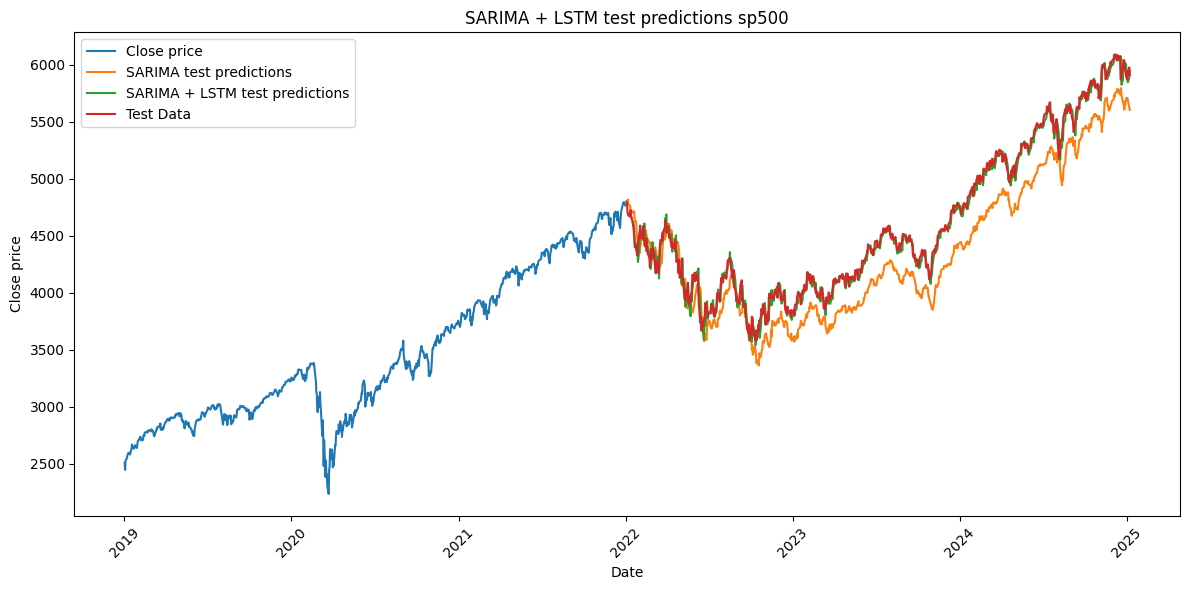

MSE: 3708.4718942465333
RMSE: 60.89722402742619
MAE: 47.05194177685927
R2: 0.8425115684679708


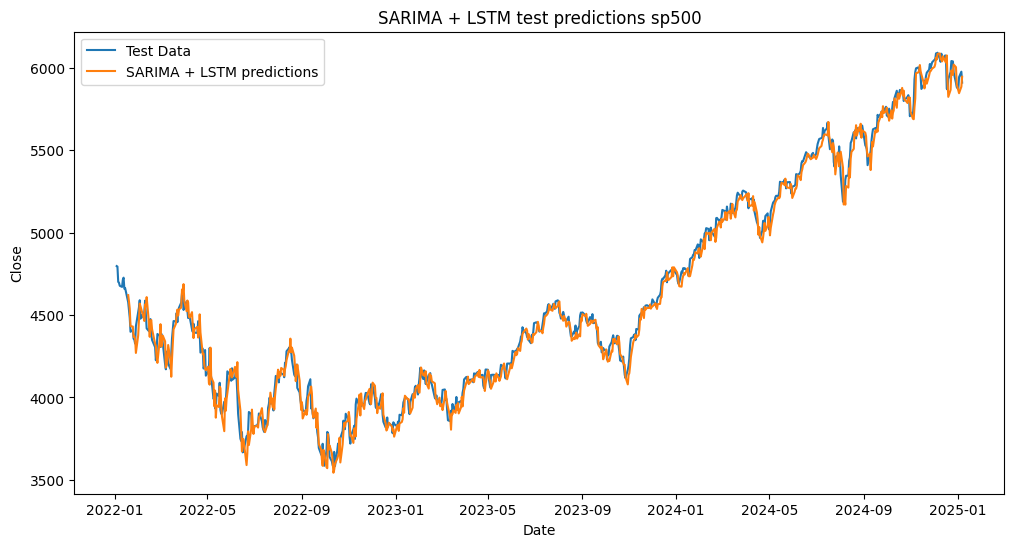

Mounted at /content/gdrive
sp500: CNN(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=128, bias=True)
    (8): ReLU()
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


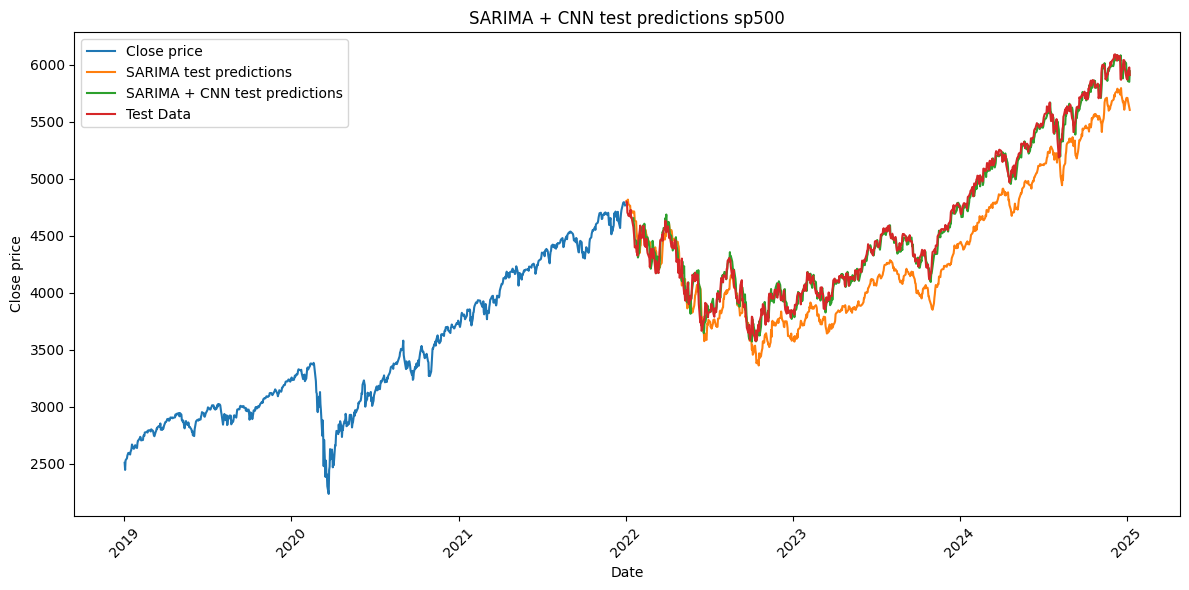

MSE: 4009.7403874337847
RMSE: 63.32251090594706
MAE: 49.04293606642272
R2: 0.8297175379845019


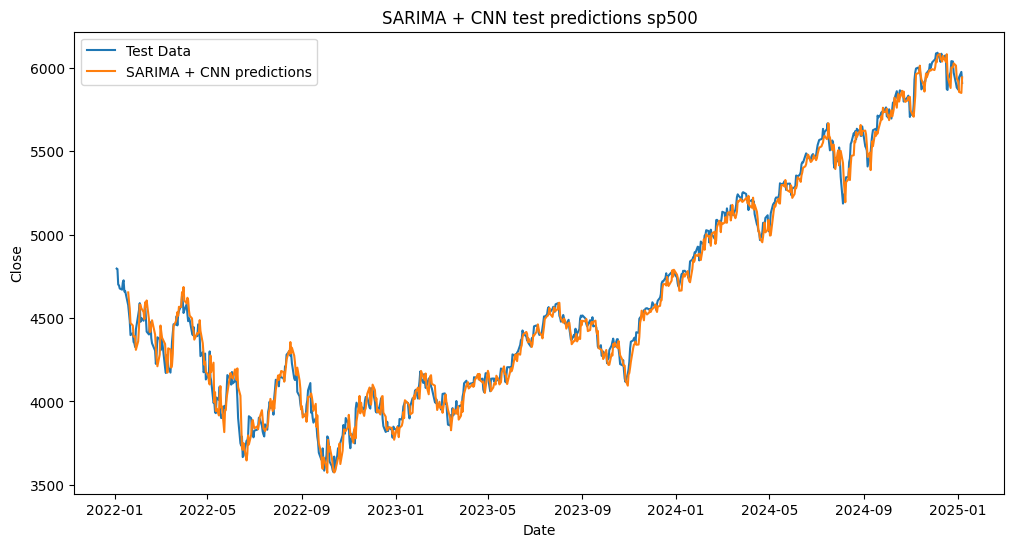

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
sp500: ParallelCNN_LSTM(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=128, bias=True)
    (8): ReLU()
  )
  (lstm): LSTM(1, 512, batch_first=True)
  (fc_lstm): Linear(in_features=512, out_features=128, bias=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


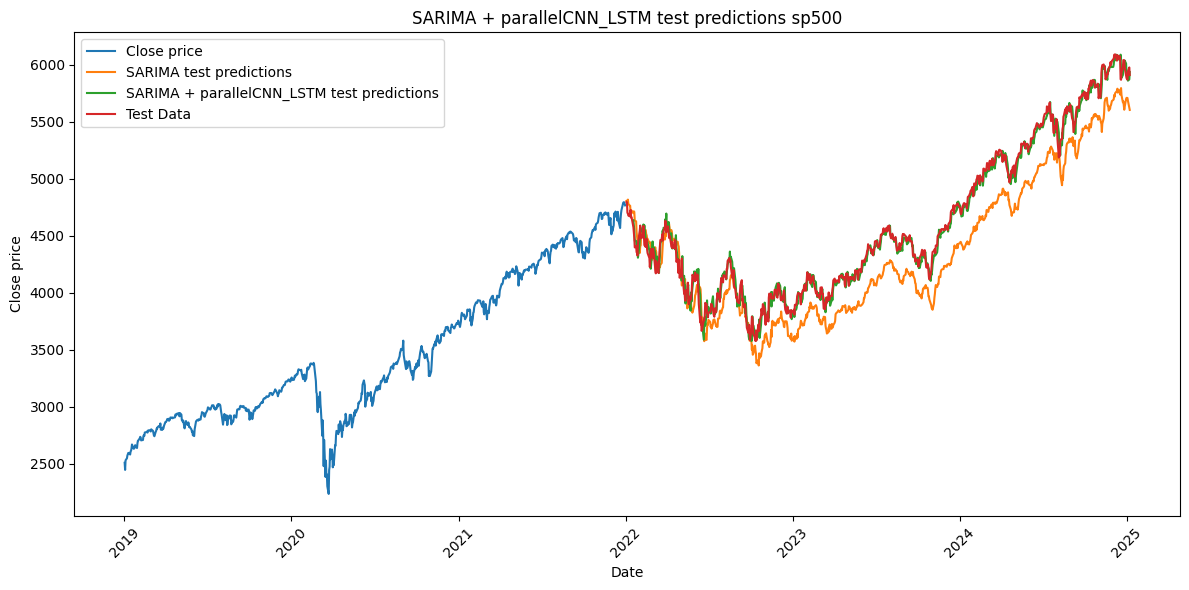

MSE: 3740.160674962793
RMSE: 61.15685304986509
MAE: 47.703017138244505
R2: 0.8411658345607222


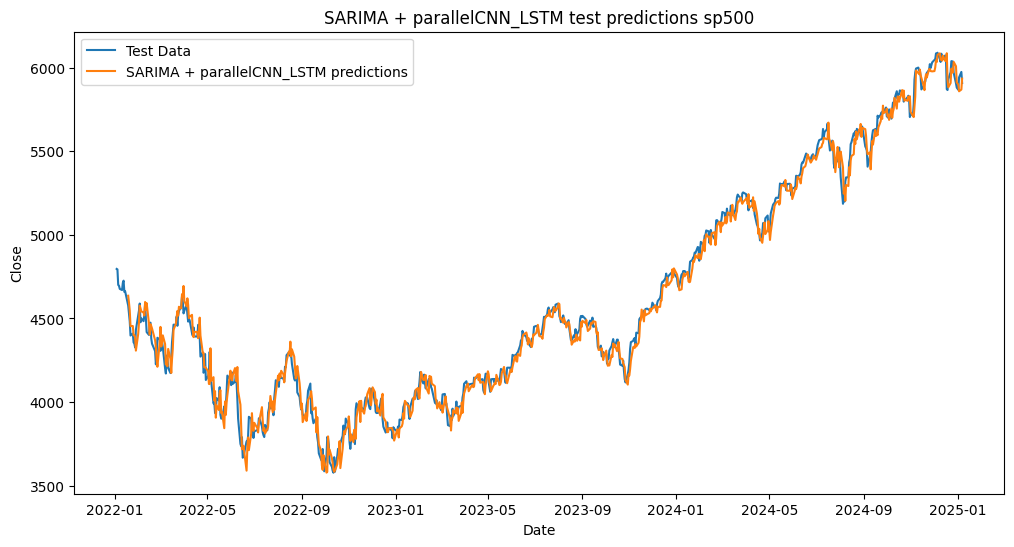

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
sp500: LSTM_CNN(
  (lstm): LSTM(1, 512, batch_first=True)
  (cnn): Sequential(
    (0): Conv1d(512, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)


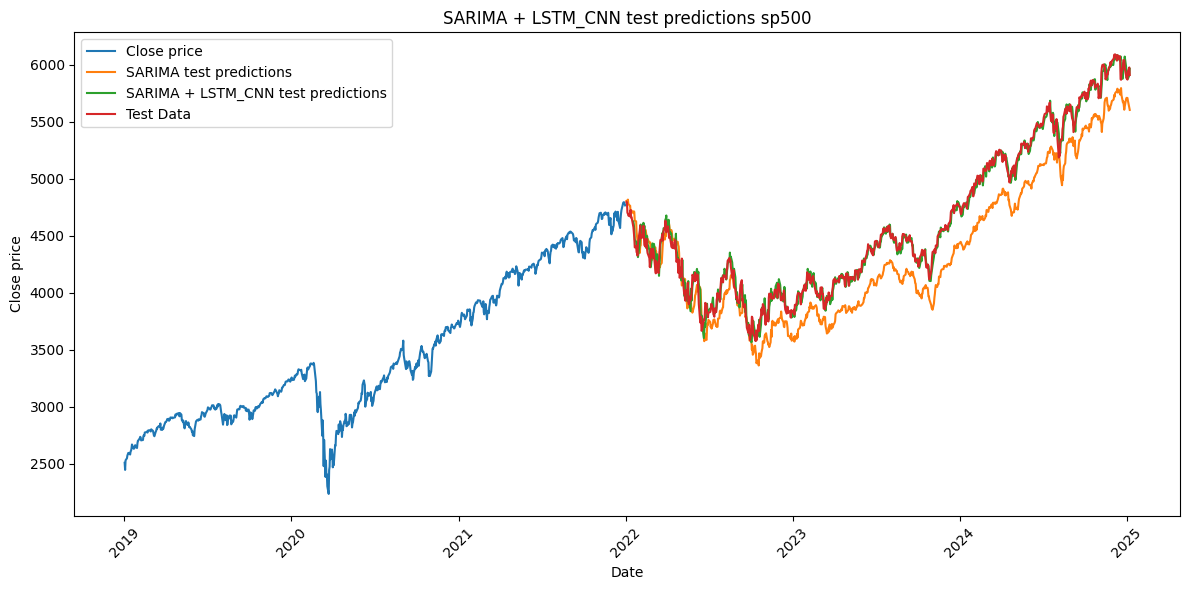

MSE: 3596.000757023035
RMSE: 59.966663714292416
MAE: 46.288765628519194
R2: 0.847287903168372


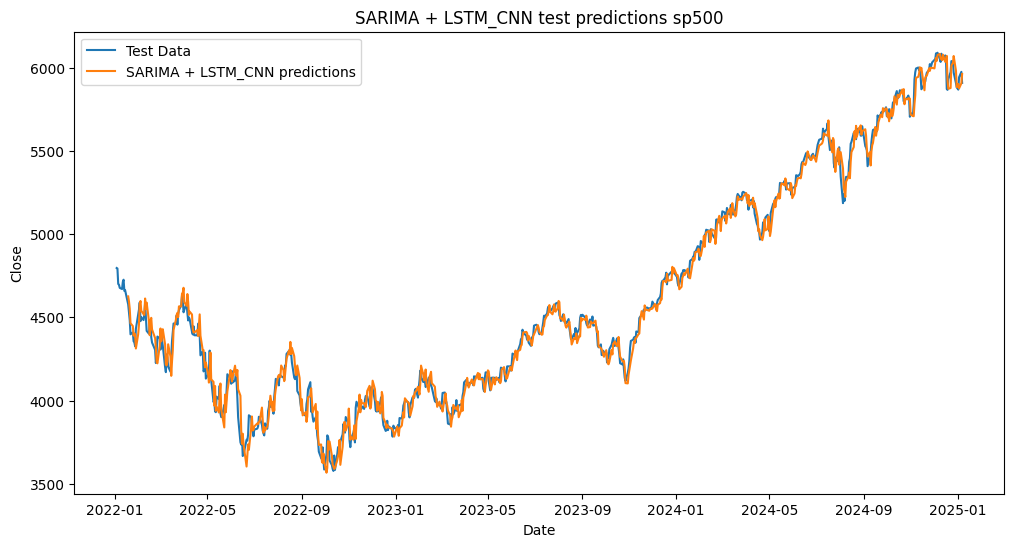

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
eur_usd: LSTM(
  (lstm): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


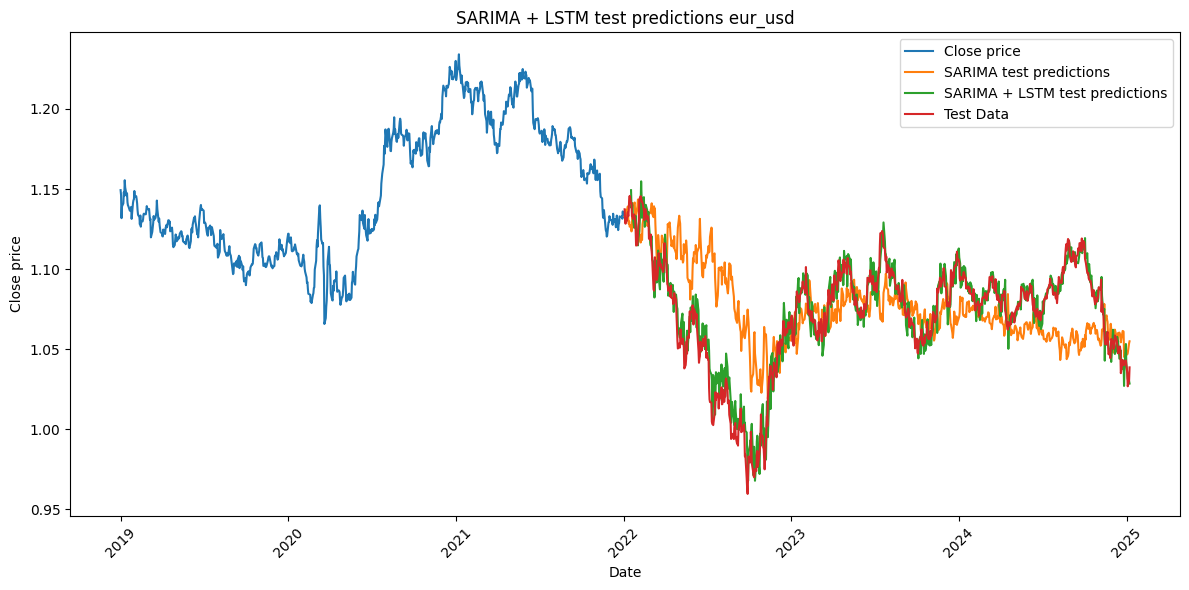

MSE: 7.026749260384786e-05
RMSE: 0.008382570763426208
MAE: 0.00650347624721857
R2: 0.9444289953482573


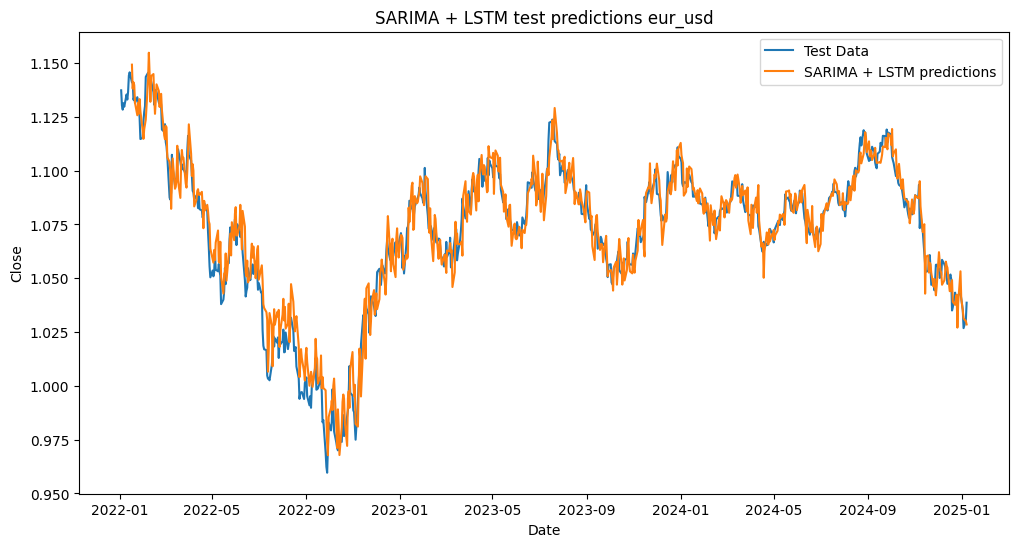

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
eur_usd: CNN(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=128, bias=True)
    (8): ReLU()
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


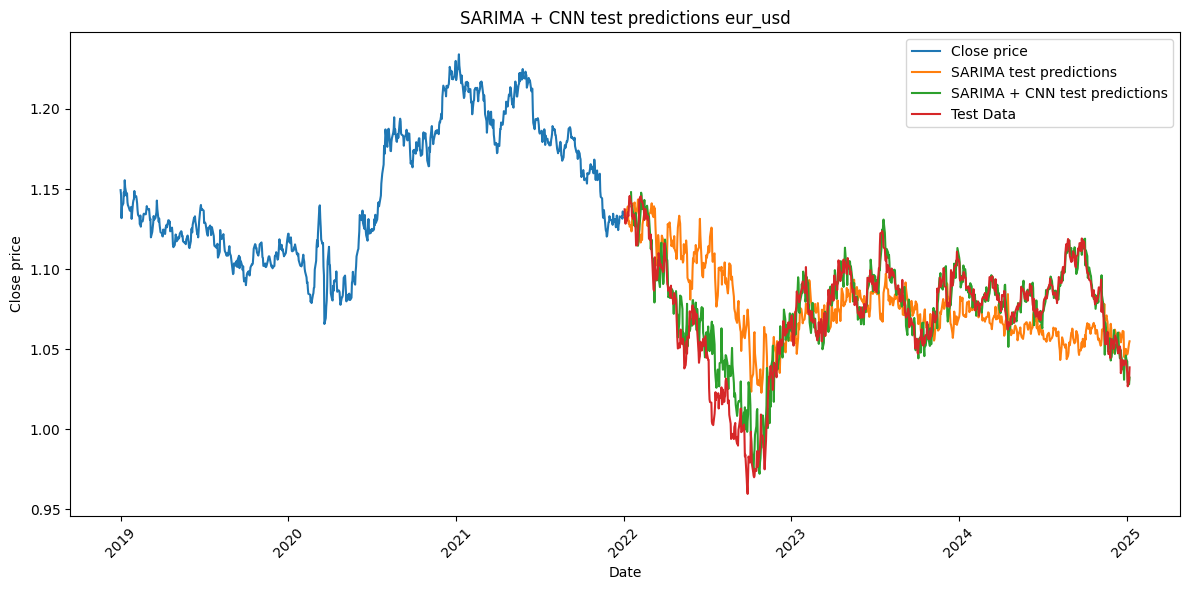

MSE: 0.0001415051499393651
RMSE: 0.011895593719498204
MAE: 0.008036210517573798
R2: 0.8880907364966174


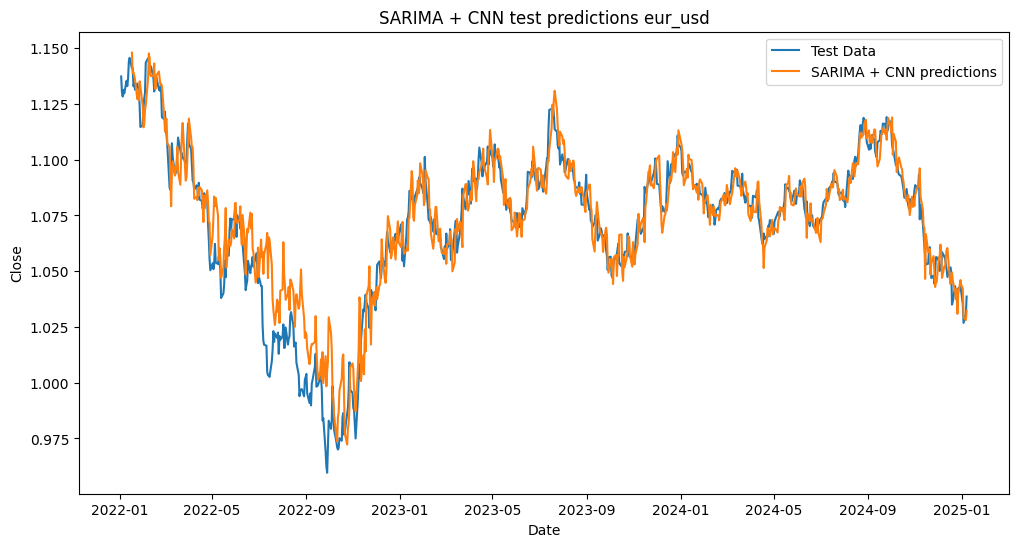

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
eur_usd: ParallelCNN_LSTM(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=128, bias=True)
    (8): ReLU()
  )
  (lstm): LSTM(1, 512, batch_first=True)
  (fc_lstm): Linear(in_features=512, out_features=128, bias=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


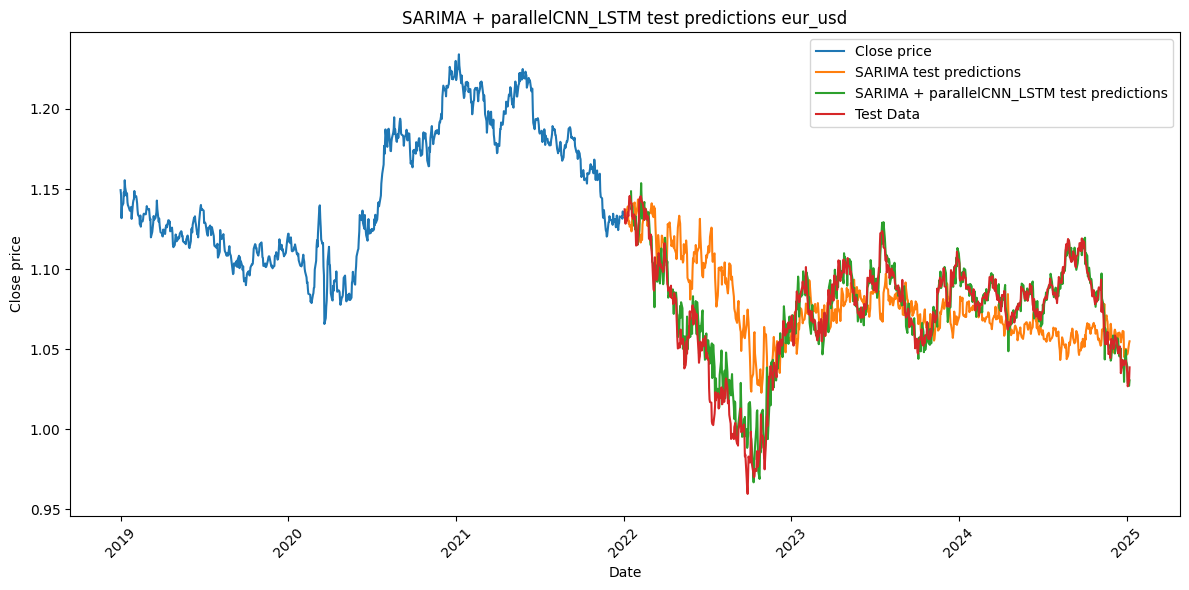

MSE: 9.177800421394466e-05
RMSE: 0.009580083726875495
MAE: 0.006747035696273527
R2: 0.9274174200600195


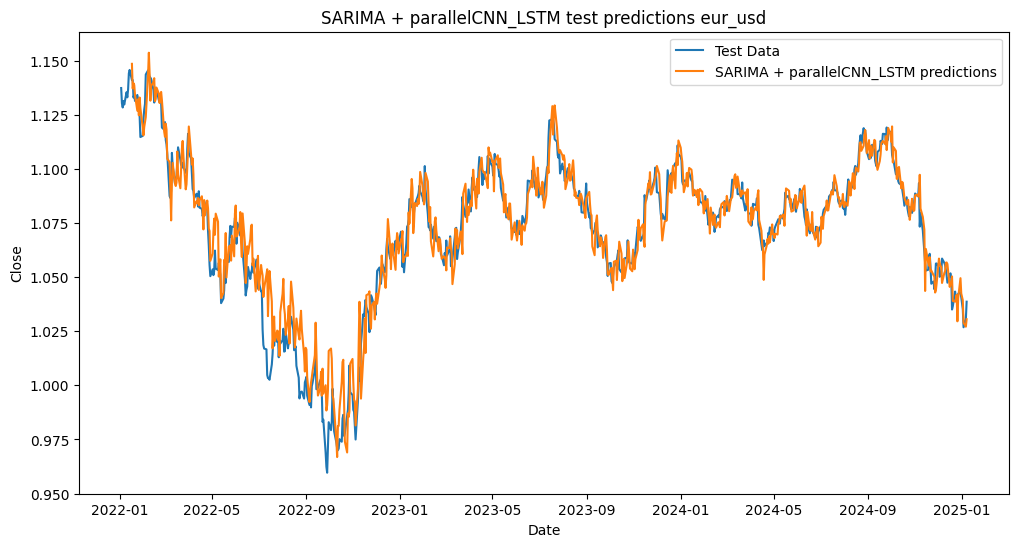

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
eur_usd: LSTM_CNN(
  (lstm): LSTM(1, 512, batch_first=True)
  (cnn): Sequential(
    (0): Conv1d(512, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)


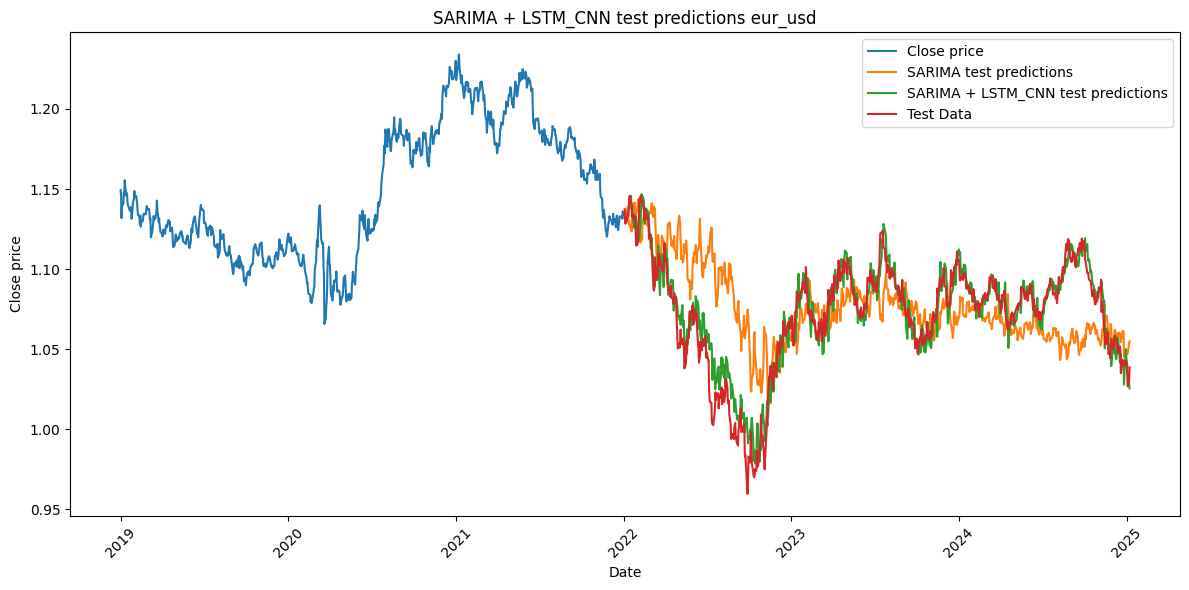

MSE: 0.00010895644405802977
RMSE: 0.010438220349179728
MAE: 0.00783882106321012
R2: 0.9138318611463511


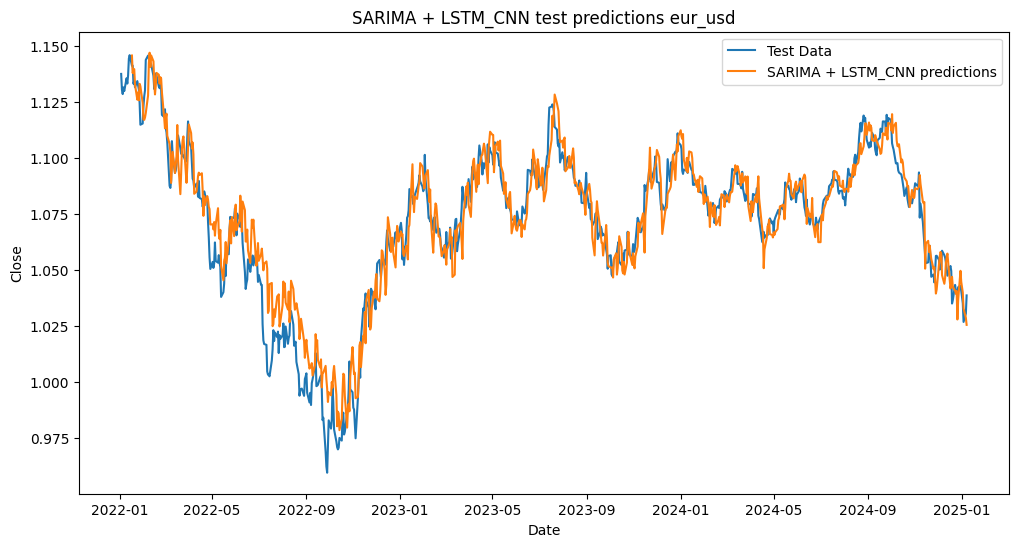

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
model_names = ['LSTM', 'CNN', 'parallelCNN_LSTM', 'LSTM_CNN'] #model names
models = [LSTM_model, CNN_model, parallelCNNLSTM_model, LSTM_CNN_model] #model istannces

for name, _ in datasets.items():
    for model_name, model in zip(model_names, models):
        print(f"{name}: {model[name]}")

        #generate predictions
        prediction, actual = inference(model[name], test_loader[name])
        train_predictions, actual_train = inference(model[name], train_val_loader[name])

        #rescale predictions
        prediction = scaler[name].inverse_transform(prediction)
        actual = scaler[name].inverse_transform(actual)
        train_predictions = scaler[name].inverse_transform(train_predictions)
        actual_train = scaler[name].inverse_transform(actual_train)

        #set index
        prediction = pd.DataFrame(prediction)
        prediction.index = test_data[name][10:].index
        actual = pd.DataFrame(actual)
        actual.index = test_data[name][10:].index

        train_predictions = pd.DataFrame(train_predictions)
        train_predictions.index = train_val_data[name][10:].index
        actual_train = pd.DataFrame(actual_train)
        actual_train.index = train_val_data[name][10:].index

        #combine arima and NN predictions on test set
        SARIMA_NN_test_predictions = SARIMA_test_predictions[name][10:] + prediction[0]

        #combine arima and NN predictions on train set
        # SARIMA_NN_train_predictions = SARIMA_fitted_values[name].iloc[10:,0].values + train_val_predictions[0]


        #predictions on test set
        plt.figure(figsize=(12, 6))
        sns.lineplot(data = Close_price[name].loc[train_val_data[name].index], label="Close price")
        sns.lineplot(x=test_data[name].index, y=SARIMA_test_predictions[name].values.ravel(), label="SARIMA test predictions")
        # sns.lineplot(x=test_data.index, y=XGBoost_predictions.values.ravel(), label="XGBoost predictions")
        sns.lineplot(x=test_data[name].index[10:], y=SARIMA_NN_test_predictions, label= f"SARIMA + {model_name} test predictions")
        sns.lineplot(x=test_data[name].index, y=Close_price[name].loc[test_data[name].index ], label="Test Data")
        plt.title(f'SARIMA + {model_name} test predictions {name}')
        plt.xlabel('Date')
        plt.ylabel('Close price')
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.tight_layout() # Automatically adjusts the layout
        plt.legend()
        plt.show()


        #compute metrics
        mse = mean_squared_error(actual, prediction)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actual, prediction)
        r2 = r2_score(actual, prediction)

        print(f"MSE: {mse}")
        print(f"RMSE: {rmse}")
        print(f"MAE: {mae}")
        print(f"R2: {r2}")


        #close up
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=test_data[name].index, y=Close_price[name].loc[test_data[name].index ], label="Test Data")
        sns.lineplot(x=test_data[name][10:].index, y=SARIMA_NN_test_predictions, label=f"SARIMA + {model_name} predictions")
        plt.title(f'SARIMA + {model_name} test predictions {name}')
        plt.show()

        #save ARIMA + NN predictions
        drive.mount('/content/gdrive')
        file_path = f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/CNN LSTM/{name}/SARIMA_{model_name}_predictions.csv'
        SARIMA_NN_test_predictions = pd.Series(SARIMA_NN_test_predictions, index=test_data[name].index)
        SARIMA_NN_test_predictions.to_csv(file_path, index=True)
